# H4: Tissue Region Proportions Differ by Genotype

**Rationale:** SH2B3 deficiency alters splenic architecture with white pulp expansion. Different rs3184504 genotypes may show altered compartment proportions.

> **Caveat:** With n=3–4 per group, these analyses are exploratory. Effect sizes are more informative than p-values.

In [1]:
import sys
sys.path.insert(0, '.')
from data_utils import *
setup_style()

df = load_data()
regions = get_regions(df)

# Per-image region areas
area = regions[regions['Classification'].isin(MAIN_REGIONS)].groupby(
    ['Image', 'Sample', 'Genotype', 'Classification'], observed=True
)['Area µm^2'].sum().reset_index()
area.rename(columns={'Classification': 'Region', 'Area µm^2': 'Area_um2'}, inplace=True)
area['Area_mm2'] = area['Area_um2'] / 1e6

# Total tissue area per image
total = area.groupby(['Image', 'Sample', 'Genotype'], observed=True)['Area_um2'].sum().reset_index(name='Total_um2')
area = area.merge(total, on=['Image', 'Sample', 'Genotype'])
area['Fraction'] = area['Area_um2'] / area['Total_um2']

# Derived metrics per image
pivot = area.pivot_table(index=['Image', 'Sample', 'Genotype'],
                         columns='Region', values='Area_um2', fill_value=0).reset_index()
pivot['WhitePulp'] = pivot.get('Follicle', 0) + pivot.get('PALS', 0)
pivot['Total'] = pivot[MAIN_REGIONS].sum(axis=1)
pivot['WP_Fraction'] = pivot['WhitePulp'] / pivot['Total']
pivot['WP_RP_Ratio'] = pivot['WhitePulp'] / pivot['RedPulp']
pivot['Fol_PALS_Ratio'] = pivot['Follicle'] / pivot['PALS'].replace(0, np.nan)
pivot['Total_mm2'] = pivot['Total'] / 1e6

print(f"Images: {len(pivot)}, Samples per genotype: {pivot.groupby('Genotype', observed=True)['Sample'].nunique().to_dict()}")

Images: 10, Samples per genotype: {'C/C': 3, 'C/T': 4, 'T/T': 3}


/tmp/ipykernel_260619/2208817703.py:22: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = area.pivot_table(index=['Image', 'Sample', 'Genotype'],


## Figure 1: Tissue Composition per Image (Stacked Bar)

/tmp/ipykernel_260619/2310635709.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frac_pivot = area.pivot_table(index=['Sample', 'Genotype'],


Saved: analysis/figures/H4_tissue_composition_stacked.png


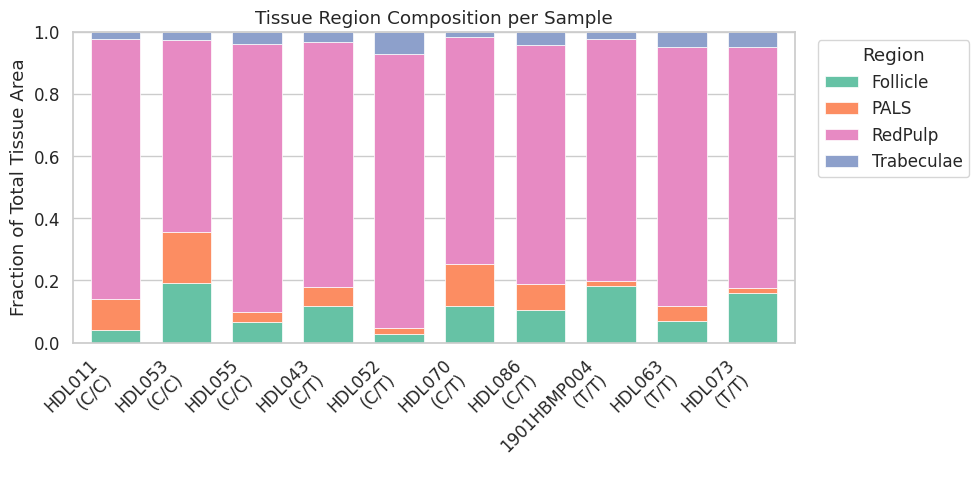

In [2]:
# Prepare fractions pivot sorted by genotype
frac_pivot = area.pivot_table(index=['Sample', 'Genotype'],
                              columns='Region', values='Fraction', fill_value=0)
frac_pivot = frac_pivot[MAIN_REGIONS]
frac_pivot = frac_pivot.sort_index(level='Genotype')

region_colors = {'Follicle': '#66c2a5', 'PALS': '#fc8d62',
                 'RedPulp': '#e78ac3', 'Trabeculae': '#8da0cb'}

fig, ax = plt.subplots(figsize=(10, 5))
frac_pivot.plot(kind='bar', stacked=True, color=[region_colors[r] for r in MAIN_REGIONS],
                ax=ax, width=0.7, edgecolor='white', linewidth=0.5)

# Genotype separator lines
geno_counts = frac_pivot.index.get_level_values('Genotype')
labels = [f"{s}\n({g})" for s, g in frac_pivot.index]
ax.set_xticklabels(labels, rotation=45, ha='right')

ax.set_ylabel('Fraction of Total Tissue Area')
ax.set_xlabel('')
ax.set_title('Tissue Region Composition per Sample')
ax.legend(title='Region', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_ylim(0, 1)

fig.tight_layout()
save_figure(fig, 'H4_tissue_composition_stacked')
plt.show()

## Figure 2: Region Fraction by Genotype (2×2)

/tmp/ipykernel_260619/1143441476.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rd, x='Genotype', y='Fraction', order=GENO_ORDER,
/tmp/ipykernel_260619/1143441476.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=rd, x='Genotype', y='Fraction', order=GENO_ORDER,
/tmp/ipykernel_260619/1143441476.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rd, x='Genotype', y='Fraction', order=GENO_ORDER,
/tmp/ipykernel_260619/1143441476.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be r

/tmp/ipykernel_260619/1143441476.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rd, x='Genotype', y='Fraction', order=GENO_ORDER,
/tmp/ipykernel_260619/1143441476.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=rd, x='Genotype', y='Fraction', order=GENO_ORDER,


Saved: analysis/figures/H4_region_fractions.png


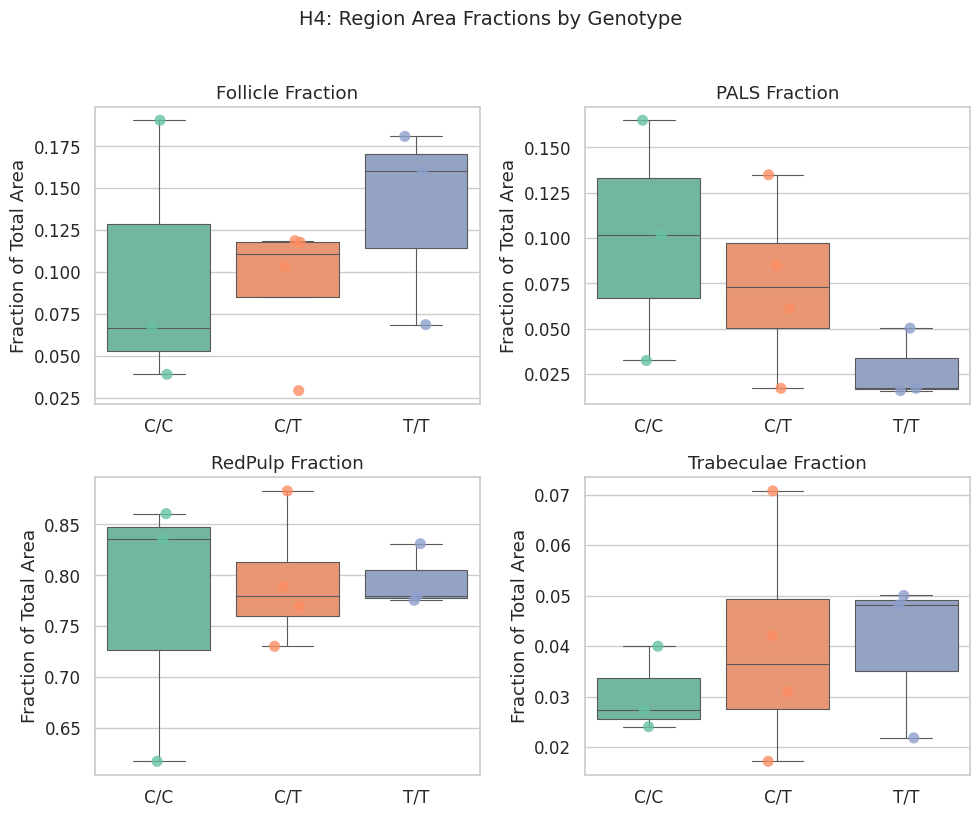

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for ax, region in zip(axes.flat, MAIN_REGIONS):
    rd = area[area['Region'] == region]
    sns.boxplot(data=rd, x='Genotype', y='Fraction', order=GENO_ORDER,
                palette=GENO_PALETTE, ax=ax, linewidth=0.8, fliersize=0)
    sns.stripplot(data=rd, x='Genotype', y='Fraction', order=GENO_ORDER,
                  palette=GENO_PALETTE, ax=ax, size=8, alpha=0.8)
    ax.set_title(f'{region} Fraction')
    ax.set_xlabel('')
    ax.set_ylabel('Fraction of Total Area')

fig.suptitle('H4: Region Area Fractions by Genotype', fontsize=14, y=1.02)
fig.tight_layout()
save_figure(fig, 'H4_region_fractions')
plt.show()

## Figure 3: White Pulp Metrics

/tmp/ipykernel_260619/3938847976.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pivot, x='Genotype', y=col, order=GENO_ORDER,
/tmp/ipykernel_260619/3938847976.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=pivot, x='Genotype', y=col, order=GENO_ORDER,
/tmp/ipykernel_260619/3938847976.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pivot, x='Genotype', y=col, order=GENO_ORDER,
/tmp/ipykernel_260619/3938847976.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0

Saved: analysis/figures/H4_white_pulp_metrics.png


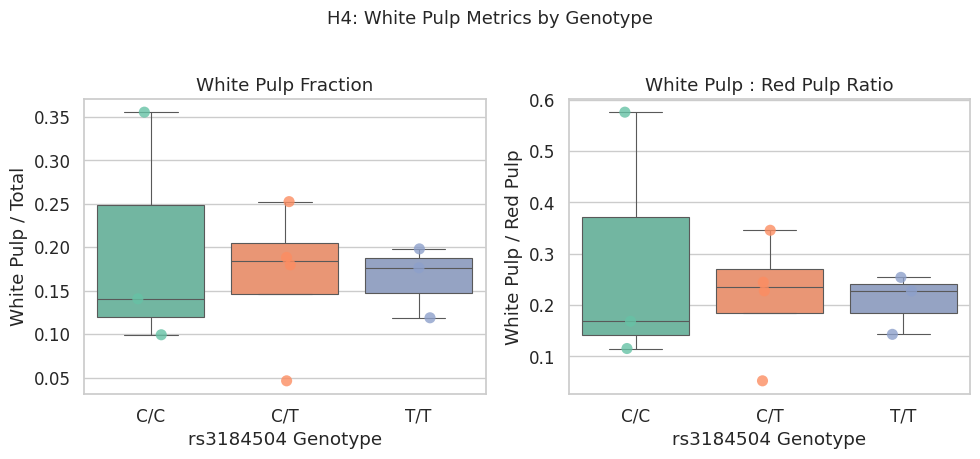

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

for ax, col, ylabel, title in zip(axes,
    ['WP_Fraction', 'WP_RP_Ratio'],
    ['White Pulp / Total', 'White Pulp / Red Pulp'],
    ['White Pulp Fraction', 'White Pulp : Red Pulp Ratio']):
    sns.boxplot(data=pivot, x='Genotype', y=col, order=GENO_ORDER,
                palette=GENO_PALETTE, ax=ax, linewidth=0.8, fliersize=0)
    sns.stripplot(data=pivot, x='Genotype', y=col, order=GENO_ORDER,
                  palette=GENO_PALETTE, ax=ax, size=8, alpha=0.8)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('rs3184504 Genotype')

fig.suptitle('H4: White Pulp Metrics by Genotype', fontsize=13, y=1.02)
fig.tight_layout()
save_figure(fig, 'H4_white_pulp_metrics')
plt.show()

## Figure 4: Follicle/PALS Ratio

/tmp/ipykernel_260619/1126728613.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pivot, x='Genotype', y='Fol_PALS_Ratio', order=GENO_ORDER,
/tmp/ipykernel_260619/1126728613.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=pivot, x='Genotype', y='Fol_PALS_Ratio', order=GENO_ORDER,


Saved: analysis/figures/H4_follicle_pals_ratio.png


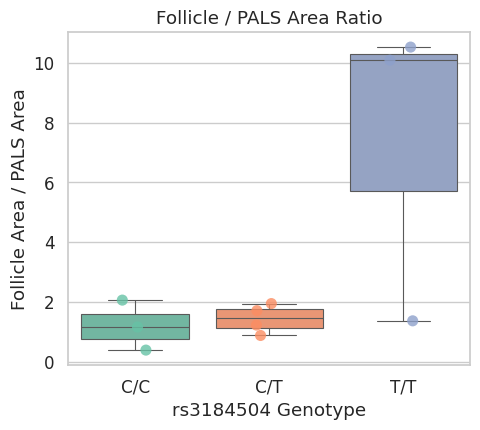

In [5]:
fig, ax = plt.subplots(figsize=(5, 4.5))
sns.boxplot(data=pivot, x='Genotype', y='Fol_PALS_Ratio', order=GENO_ORDER,
            palette=GENO_PALETTE, ax=ax, linewidth=0.8, fliersize=0)
sns.stripplot(data=pivot, x='Genotype', y='Fol_PALS_Ratio', order=GENO_ORDER,
              palette=GENO_PALETTE, ax=ax, size=8, alpha=0.8)
ax.set_title('Follicle / PALS Area Ratio')
ax.set_ylabel('Follicle Area / PALS Area')
ax.set_xlabel('rs3184504 Genotype')

fig.tight_layout()
save_figure(fig, 'H4_follicle_pals_ratio')
plt.show()

## Figure 5: Total Tissue Area by Genotype

/tmp/ipykernel_260619/2301571334.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pivot, x='Genotype', y='Total_mm2', order=GENO_ORDER,
/tmp/ipykernel_260619/2301571334.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=pivot, x='Genotype', y='Total_mm2', order=GENO_ORDER,


Saved: analysis/figures/H4_total_tissue_area.png


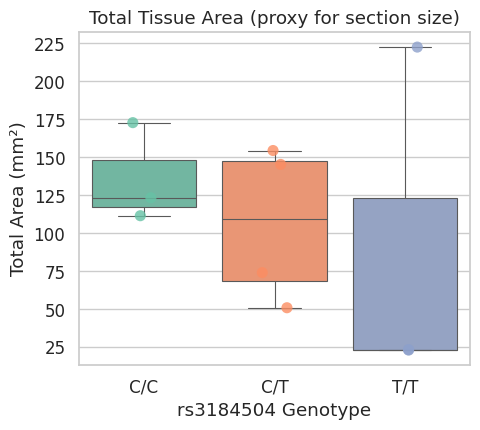

In [6]:
fig, ax = plt.subplots(figsize=(5, 4.5))
sns.boxplot(data=pivot, x='Genotype', y='Total_mm2', order=GENO_ORDER,
            palette=GENO_PALETTE, ax=ax, linewidth=0.8, fliersize=0)
sns.stripplot(data=pivot, x='Genotype', y='Total_mm2', order=GENO_ORDER,
              palette=GENO_PALETTE, ax=ax, size=8, alpha=0.8)
ax.set_title('Total Tissue Area (proxy for section size)')
ax.set_ylabel('Total Area (mm²)')
ax.set_xlabel('rs3184504 Genotype')

fig.tight_layout()
save_figure(fig, 'H4_total_tissue_area')
plt.show()

## Summary Tables

In [7]:
# Proportions summary
prop_summary = area.groupby(['Region', 'Genotype'], observed=True)['Fraction'].agg(
    ['count', 'mean', 'std', 'median']
).round(4).reset_index()
prop_summary.columns = ['Region', 'Genotype', 'N', 'Mean', 'SD', 'Median']

save_table(prop_summary, 'H4_proportions_summary')
display(prop_summary)

Saved: analysis/tables/H4_proportions_summary.csv


,Region,Genotype,N,Mean,SD,Median
0,Follicle,C/C,3,0.0988,0.0807,0.0668
1,Follicle,C/T,4,0.0922,0.0426,0.1106
2,Follicle,T/T,3,0.1367,0.0599,0.1605
3,PALS,C/C,3,0.0997,0.0662,0.1018
4,PALS,C/T,4,0.0745,0.0491,0.0730
5,PALS,T/T,3,0.0278,0.0195,0.0172
6,RedPulp,C/C,3,0.7710,0.1338,0.8352
7,RedPulp,C/T,4,0.7930,0.0648,0.7794
8,RedPulp,T/T,3,0.7955,0.0309,0.7800
9,Trabeculae,C/C,3,0.0304,0.0084,0.0273


In [8]:
# Derived metrics summary
derived_cols = ['WP_Fraction', 'WP_RP_Ratio', 'Fol_PALS_Ratio', 'Total_mm2']
derived_summary = []
for col in derived_cols:
    s = pivot.groupby('Genotype', observed=True)[col].agg(['count', 'mean', 'std', 'median']).round(4)
    s['Metric'] = col
    derived_summary.append(s.reset_index())

derived_df = pd.concat(derived_summary, ignore_index=True)
derived_df.columns = ['Genotype', 'N', 'Mean', 'SD', 'Median', 'Metric']
derived_df = derived_df[['Metric', 'Genotype', 'N', 'Mean', 'SD', 'Median']]

save_table(derived_df, 'H4_derived_metrics_summary')
display(derived_df)

Saved: analysis/tables/H4_derived_metrics_summary.csv


,Metric,Genotype,N,Mean,SD,Median
0,WP_Fraction,C/C,3,0.1985,0.1375,0.1407
1,WP_Fraction,C/T,4,0.1667,0.0866,0.1841
2,WP_Fraction,T/T,3,0.1645,0.0410,0.1764
3,WP_RP_Ratio,C/C,3,0.2866,0.2520,0.1684
4,WP_RP_Ratio,C/T,4,0.2177,0.1219,0.2363
5,WP_RP_Ratio,T/T,3,0.2082,0.0580,0.2274
6,Fol_PALS_Ratio,C/C,3,1.1980,0.8378,1.1555
7,Fol_PALS_Ratio,C/T,4,1.4340,0.4794,1.4619
8,Fol_PALS_Ratio,T/T,3,7.3278,5.1706,10.0909
9,Total_mm2,C/C,3,135.9117,32.5300,123.3567


In [9]:
# Statistical tests
all_stats = []

# Per-region fraction tests
for region in MAIN_REGIONS:
    rd = area[area['Region'] == region]
    all_stats.append(full_stats_table(rd, 'Fraction', label=f'{region} fraction'))

# Derived metric tests
for col, label in [('WP_Fraction', 'WP fraction'), ('WP_RP_Ratio', 'WP/RP ratio'),
                    ('Fol_PALS_Ratio', 'Follicle/PALS ratio'), ('Total_mm2', 'Total area')]:
    all_stats.append(full_stats_table(pivot, col, label=label))

stats_df = pd.concat(all_stats, ignore_index=True)
save_table(stats_df, 'H4_statistical_tests')
display(stats_df)

Saved: analysis/tables/H4_statistical_tests.csv


,Test,Metric,Statistic,p,Effect_Size
0,Kruskal-Wallis,Follicle fraction,1.063636,0.587536,
1,Mann-Whitney (C/C vs C/T),Follicle fraction,6.000000,1.000000,r=0.000
2,Mann-Whitney (C/C vs T/T),Follicle fraction,3.000000,0.700000,r=0.333
3,Mann-Whitney (C/T vs T/T),Follicle fraction,3.000000,0.400000,r=0.500
4,Spearman dosage,Follicle fraction,0.269680,0.451139,rho=0.270
5,Kruskal-Wallis,PALS fraction,3.254545,0.196465,
6,Mann-Whitney (C/C vs C/T),PALS fraction,8.000000,0.628571,r=-0.333
7,Mann-Whitney (C/C vs T/T),PALS fraction,8.000000,0.200000,r=-0.778
8,Mann-Whitney (C/T vs T/T),PALS fraction,10.000000,0.228571,r=-0.667
9,Spearman dosage,PALS fraction,-0.584307,0.076089,rho=-0.584
